In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import seaborn as sb
import os
import time
import math

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_real_data = "/content/drive/My Drive/Google Drive/zipcombo.dat"

Mounted at /content/drive


In [4]:
path_real_data = "/content/drive/My Drive/zipcombo.dat"
data = np.loadtxt(path_real_data)
data_samples = data[:, 1:]; data_labels = data[:, 0]

In [5]:
# Model Construction Functions

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

def build_model2(layers, nodes_per_layer, learn_rate, filter_bank, num_labels = 10, threshold = 0.5, hlactivation = "tanh", optimizer_name = "Adam"
, reg_coeff = 0, drop_prob = 0):
    """
    Constructs the model and return training, predict, loss evaluation, given the fed data and labels. This fed data and labels could
    be training or test labels
    inputs:
        layers : (1x1) number of layers in the MLP
        nodes_per_layer : (1 x L+1) array specifiying #nodes in each layer
        learn_rate : (1x1) learning rate
        num_labels: (1x1) number of classes in the problem, defaults to 10 as specificied
        threshold: (1x1) threshold posterior to consider as class 1
        hlactivation = (string) argument on the activation of hidden layers. Either "tanh", "relu" or "sigmoid". Assume all layers activation
        are identical except the output layer which will always be softmax
        optimizer_name : Name of the optimizer to use. Default is Adam Optimizer
        reg_coeff : L2 Regularization coeff, default is 0 i.e. no regularization
        drop_prob : Probability of drop out, defaults to 0 i.e. no dropout
    """
    # Construct Model
    # Here, we don't fix the batch size so that later, we can flexibly use the loss operator here to predict for whole data set
    # x = tf.placeholder(tf.float32, shape = [None, nodes_per_layer[0]]) # to hold the fed in data
    x = tf.placeholder(tf.float32, shape = [None, 16, 16, 1])
    y = tf.placeholder(tf.int64, shape = [None, num_labels]) # to hold one-hot encodings of the labels
    isTrain = tf.placeholder(tf.bool, shape = None) # to enable/ disable dropout

    # Define Hidden Layers
    # Convolutional layers
    wc1 = tf.get_variable('W0', shape=(3,3,1,filter_bank), initializer=tf.initializers.glorot_uniform())
    bc1 = tf.get_variable('B0', shape=(filter_bank), initializer=tf.initializers.glorot_uniform())

    wc2 = tf.get_variable('W1', shape=(3,3,filter_bank,2*filter_bank), initializer=tf.initializers.glorot_uniform())
    bc2 = tf.get_variable('B1', shape=(2*filter_bank), initializer=tf.initializers.glorot_uniform())
    # wc1 = tf.Variable(initial_value = np.random.normal(size = (3,3,1,32)).astype(np.float32))
    # bc1 = tf.Variable(initial_value = np.random.normal(size = (32)).astype(np.float32))
    conv1 = conv2d(x, wc1, bc1)
    conv1 = maxpool2d(conv1, k = 2)
    conv2 = conv2d(conv1, wc2, bc2)
    out = maxpool2d(conv2, k = 2)
    out_shape = out.shape; out_flatten = out_shape[1] * out_shape[2] * out_shape[3]
    # Reshape
    out = tf.reshape(out, shape = [-1, out_flatten])

    # Fully connected layers
    for layer in range(1,len(nodes_per_layer)-1):
        out_node = nodes_per_layer[layer]
        if hlactivation == 'tanh':
            out = tf.layers.dense(out, out_node, activation = tf.nn.tanh, kernel_initializer =  tf.initializers.glorot_uniform,
                                    bias_initializer = tf.initializers.glorot_uniform)
            out = tf.layers.dropout(out, rate = drop_prob, training = isTrain)
        elif hlactivation == 'relu':
            out = tf.layers.dense(out, out_node, activation = tf.nn.relu, kernel_initializer =  tf.initializers.glorot_uniform,
                                    bias_initializer = tf.initializers.glorot_uniform)
            out = tf.layers.dropout(out, rate = drop_prob, training = isTrain)
        else:
            out = tf.layers.dense(out, out_node, activation = tf.nn.sigmoid, kernel_initializer =  tf.initializers.glorot_uniform,
                                    bias_initializer = tf.initializers.glorot_uniform)
            out = tf.layers.dropout(out, rate = drop_prob, training = isTrain)
    
    # Define output layer
    out = tf.layers.dense(out, num_labels, kernel_initializer =  tf.initializers.glorot_uniform, bias_initializer = tf.initializers.glorot_uniform) # create linear layer
    out_softmax = tf.nn.softmax(out)

    # Define loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out))

    # Add L2 Regularization
    L2norms = [tf.nn.l2_loss(weights) for weights in tf.trainable_variables()]
    L2 = tf.reduce_sum(L2norms)
    loss_L2 = loss + reg_coeff * L2

    # Add Predictions
    predictions = tf.reshape(tf.argmax(out,1), [-1]) # for predictions, can argmax over un-normalized probabilities, since softmax doesnt change max position

    # Add Training Optimizer and Operation
    if optimizer_name == 'Adam':
        optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
    elif optimizer_name == 'SGD':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = learn_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = tf.train.RMSPropOptimizer(learning_rate = learn_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = tf.train.AdagradOptimizer(learning_rate = learn_rate)

    train_op = optimizer.minimize(loss_L2)

    # return the model as a dictionary, containing the loss evaluator (without L2), loss (with L2), predictions (in terms of labels)
    # train operation, and last layer output evaluator. ALso return the placeholders so we can feed later
    model_dict = {'loss': loss
                 ,'loss_L2': loss_L2
                 ,'predictions': predictions
                 ,'train_op': train_op
                 ,'out': out_softmax
                 , 'batch_size': batch_size
                 , 'input': x
                 , 'targets': y
                 , 'isTrain': isTrain}
    
    return model_dict


def train_model2(model, n_epochs, batch_size, x_train, y_train, y_train_oh, x_val, y_val, y_val_oh):
    """
    Performs training for n_epochs, using the given model, training data. Also evaluates training and validation acc and loss
    after every epoch.
    """
    # create arrays to store loss and accuracy at the end of every epoch
    train_acc_arr = []; train_loss_arr = []; val_acc_arr = []; val_loss_arr = []
    
    for epoch in range(n_epochs):
        # print("Processing Epoch", epoch + 1)
        nData = x_train.shape[0]
        
        # Shuffle training data
        permute = np.random.permutation(nData);
        x_train = x_train[permute,:]
        y_train = y_train[permute]
        y_train_oh = y_train_oh[permute,:]
        
        # split to batches
        if batch_size >= nData:
            num_batch = 1
        else:
            num_batch = (nData // batch_size) + 1
        
        # train on each batch
        for batch_ind in range(num_batch):
            low_ind = (batch_ind) * batch_size
            high_ind = min(low_ind + batch_size, nData)
        
            batch = x_train[low_ind:high_ind, :]
            batch_lab = y_train_oh[low_ind:high_ind, :]

            # create feed dictionary to predict
            feed_train = {model['input']: batch,
                         model['targets']: batch_lab,
                         model['isTrain']: True}

            # train
            sess.run(model['train_op'], feed_dict = feed_train)
            
        # At the end of each epoch, evaluate acc and loss, append to array
        feed_alltrain = {model['input']: x_train,
                        model['targets']: y_train_oh,
                        model['isTrain']: False}
        
        feed_val = {model['input']: x_val,
                    model['targets']: y_val_oh,
                   model['isTrain']: False}
        
        # Note: Change here to print L2 included loss as well
        train_pred, train_loss = sess.run([model['predictions'], model['loss']], feed_dict = feed_alltrain)
        train_acc = np.mean(train_pred == y_train)
        
        val_pred, val_loss = sess.run([model['predictions'], model['loss']], feed_dict = feed_val)
        val_acc = np.mean(val_pred == y_val)
        
        # print("Training acc and loss are",train_acc, "and", train_loss) 
        # print("Val acc and loss are", val_acc,"and", val_loss) # for debugging
        
        # Append these information
        train_acc_arr.append(train_acc); train_loss_arr.append(train_loss)
        val_acc_arr.append(val_acc); val_loss_arr.append(val_loss)
    
    return train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr

In [6]:
# Auxiliary functions to process data
def split_train_test(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    
    return train_samples, train_labels, test_samples, test_labels

def process_labels_SL(train_samples, train_labels, test_samples, test_labels):

    m = train_samples.shape[0]; m2 = test_samples.shape[0]
    # normalize train and test images
    mean_dat = np.mean(train_samples, axis = 0).reshape(1,-1); 
    sd_data = np.std(train_samples, axis = 0).reshape(1,-1)
    new_train = (train_samples - mean_dat) / sd_data
    new_test = (test_samples - mean_dat) / sd_data


    # one-hot encode the labels
    max_label = 9 # there are 10 labels, 0 to 9 inclusive
    y_onehot_train = np.zeros((m,max_label+1))
    y_onehot_test = np.zeros((m2, max_label + 1))

    y_onehot_train[np.arange(m),train_labels] = 1
    y_onehot_test[np.arange(m2), test_labels] = 1

    # also return the non-one-hot encoded labels, to compare accuracy.
    return train_samples, train_labels, new_train, y_onehot_train, test_samples, test_labels, new_test, y_onehot_test 

### Selecting the fixed hyperparameters

In [ ]:
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 98)
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [ ]:
train_samples, train_labels, new_train, train_oh, test_samples, test_labels, new_test, test_oh = process_labels_SL(train_samples, train_labels, test_samples, test_labels)

In [ ]:
# NOTE: To find the values for the fixed (non-cross validated) hyerparameters, this cell is run multiple times, and we observe the plots on the training set to see if convergence
# is obtained

# Reshape the data to be compatible with the network
new_train2 = new_train.reshape(-1, 16, 16, 1)
new_test2 = new_test.reshape(-1, 16, 16, 1)

# Construct the network
nData, dim = train_samples.shape; num_labels = 10
layers = 2; nodes_per_layer = [1000, num_labels]; learn_rate = 0.001; batch_size = nData; reg_coeff = 0; drop_prob = 0.0; filter_bank = 2
# Reset everytime we build a new model.
tf.reset_default_graph()
sess = tf.Session()
MLP = build_model2(layers, nodes_per_layer, learn_rate, filter_bank, num_labels = num_labels, reg_coeff = reg_coeff, drop_prob = drop_prob, hlactivation = 'relu', optimizer_name = "Adam")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
init = tf.initialize_all_variables()

sess.run(init)
start = time.time()
train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = train_model2(MLP, 200, batch_size, new_train2, train_labels, train_oh, new_test2, test_labels, test_oh)

print(f"Final validation error rate is {1 - val_acc_arr[-1]}")
print(time.time() - start)

In [ ]:
plot_loss_acc(train_loss_arr, train_acc_arr, title='Training Data')

In [ ]:
plot_loss_acc(val_loss_arr, val_acc_arr, title='Validation Data')

### 1) Basic Run

NOTE: By setting batch size to be larger than or equal to the number of data, means we use all the data for 1-step gradient descend, i.e. full batch since this gives the most stable updates

In [ ]:
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 88) #dummy run

In [ ]:
layer_sizes = [10, 100, 1000]; filter_banks = [2, 4, 8, 16, 32, 64]
num_classes = 10
num_iter = 20
results_train = np.zeros((len(layer_sizes), len(filter_banks),num_iter)); results_test = np.zeros((len(layer_sizes), len(filter_banks),num_iter))

num_labels = 10
# Fixed hyperparameters
learn_rate = 0.001; reg_coeff = 0; drop_prob = 0.0; n_epochs = 200; layers = 2

start = time.time()
for it in range(num_iter):
    # For each iteration re-split. But NOT re-split for every d, lest it won't be a fair comparison
    start_iter = time.time()
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    train_labels = train_labels.astype(int)
    test_labels = test_labels.astype(int)
    train_samples, train_labels, new_train, train_oh, test_samples, test_labels, new_test, test_oh = process_labels_SL(train_samples, train_labels, test_samples, test_labels)
    nData, dim = train_samples.shape
    batch_size = nData;
    new_train2 = new_train.reshape(-1, 16, 16, 1)
    new_test2 = new_test.reshape(-1, 16, 16, 1)
    print(f"Iteration {it+1}/{num_iter}")
    
    # Iterate through hyperparameters
    start_iter = time.time()
    for layer_ind in range(len(layer_sizes)):
        layer_size = layer_sizes[layer_ind]; start_d = time.time()
        for f_ind in range(len(filter_banks)):
            fb = filter_banks[f_ind]
            nodes_per_layer = [layer_size, 10];
            # Build nn
            tf.reset_default_graph()
            sess = tf.Session()
            MLP = build_model2(layers, nodes_per_layer, learn_rate, fb, num_labels = num_labels, hlactivation = 'relu')

            # Train and Predict
            init = tf.initialize_all_variables()
            sess.run(init)
            start_train = time.time()
            train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = train_model2(MLP, 200, batch_size, new_train2, train_labels, train_oh, new_test2, test_labels, test_oh)
            print(f"Training done in {time.time() - start_train}")
            test_rate = 1 - val_acc_arr[-1]; train_rate = 1 - train_acc_arr[-1]
            
            print(f"For layer size = {layer_size}, filter size = {fb}, train rate is {train_rate}, and test rate is {test_rate}")
            
            # Append results
            results_train[layer_ind, f_ind, it] = train_rate; results_test[layer_ind, f_ind, it] = test_rate
            
        print(f"All filter sizes done in {time.time() - start_d}")
    
    print(f"Iteration done in {time.time() - start_iter}")
    
print(f"{num_iter} iterations done in {time.time() - start}")

Iteration 1/20
Instructions for updating:
Use `tf.global_variables_initializer` instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Training done in 11.44508981704712
For layer size = 10, filter size = 2, train rate is 0.12032804517343376, and test rate is 0.13924731182795702
Training done in 5.051581621170044
For layer size = 10, filter size = 4, train rate is 0.07367571927937622, and test rate is 0.08763440860215055
Training done in 6.2481842041015625
For layer size = 10, filter size = 8, train rate is 0.03401452003226679, and test rate is 0.04892473118279572
Training done in 8.422730445861816
For layer size = 10, filter size = 16, train rate is 0.017881150847001925, and test rate is 0.029032258064516148
Training done in 14.646674633026123
For layer size = 10, filter size = 32, train rate is 0.0038988975531056846, and test rate is 0.01666666666666672
Training done in 27.457557678222656
For layer size = 10, filter size = 64, train rate is 0.00040333422963156895, and test rate is 0.013440860215053752
All filter sizes done in 80.02977776527405
Training done in 4.355863332748413
For layer size = 100, filter size = 2,

In [ ]:
# Prints
res_train_mean = np.mean(results_train, axis = -1); res_test_mean = np.mean(results_test, axis = -1)
res_train_std = np.std(results_train, axis = -1); res_test_std = np.std(results_test, axis = -1)
# Print train
for ls_idx in range(res_train_mean.shape[0]):
  for fs_idx in range(res_train_mean.shape[1]):
    lsize = layer_sizes[ls_idx]; fsize = filter_banks[fs_idx]
    print(f"For layer size of {lsize} and filter size of {fsize}, average training error is {res_train_mean[ls_idx, fs_idx]} with std of {res_train_std[ls_idx, fs_idx]}")
    print(f"For layer size of {lsize} and filter size of {fsize}, average test error is {res_test_mean[ls_idx, fs_idx]} with std of {res_test_std[ls_idx, fs_idx]}")

For layer size of 10 and filter size of 2, average training error is 0.15200322667383706 with std of 0.03497962855655152
For layer size of 10 and filter size of 2, average test error is 0.15881720430107527 with std of 0.03381177623667345
For layer size of 10 and filter size of 4, average training error is 0.06747781661737026 with std of 0.0064170998444307865
For layer size of 10 and filter size of 4, average test error is 0.07432795698924732 with std of 0.009287041124477053
For layer size of 10 and filter size of 8, average training error is 0.03422290938424308 with std of 0.004444913804876396
For layer size of 10 and filter size of 8, average test error is 0.04411290322580645 with std of 0.00624090273286096
For layer size of 10 and filter size of 16, average training error is 0.015279645065877933 with std of 0.0019806202263923886
For layer size of 10 and filter size of 16, average test error is 0.027123655913978507 with std of 0.00389358313050752
For layer size of 10 and filter size o

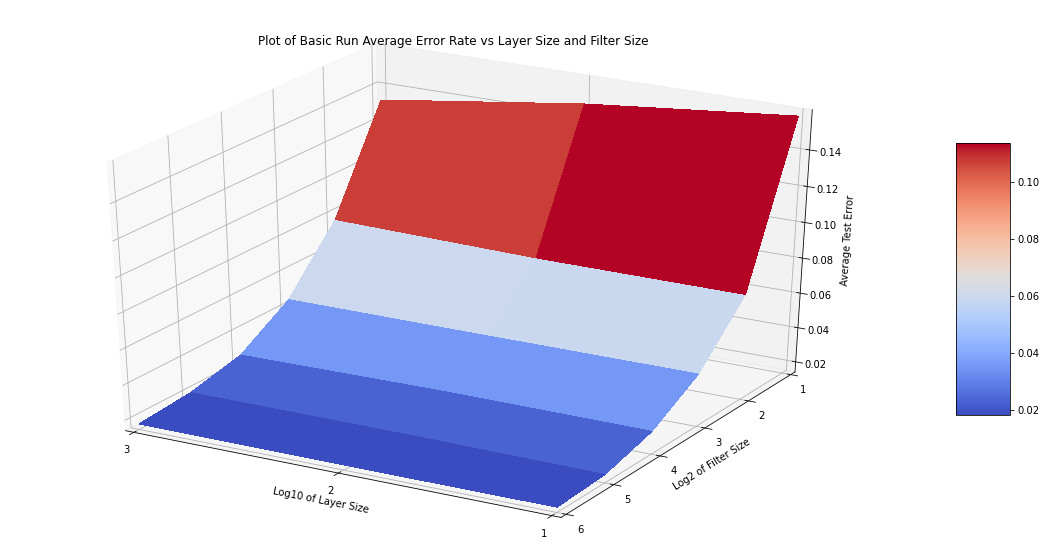

In [ ]:
# Plot 
size_pow = np.log10(np.array(layer_sizes)); 
fb_pow = np.log2(np.array(filter_banks))
# Test Results
size_powgrid, fb_powgrid = np.meshgrid(size_pow,fb_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Log10 of Layer Size")
ax.set_yticks(fb_pow)
ax.set_xticks(size_pow)
ax.set_ylim(fb_pow[-1],fb_pow[0])
ax.set_xlim(size_pow[-1],size_pow[0])
ax.set_ylabel("Log2 of Filter Size")
ax.set_zlabel("Average Test Error")
ax.set_title("Plot of Basic Run Average Error Rate vs Layer Size and Filter Size")
MSE_surf = ax.plot_surface(size_powgrid, fb_powgrid, (res_test_mean.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

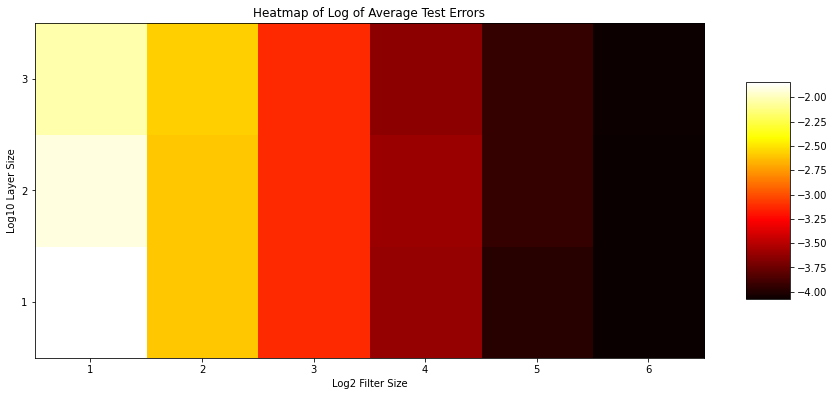

In [ ]:
# Test Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(res_test_mean), cmap="hot", origin="lower", 
           extent=[fb_pow[0]-0.5, fb_pow[-1]+0.5, size_pow[0]-0.5, size_pow[-1]+0.5])
plt.ylabel("Log10 Layer Size")
plt.yticks(size_pow)
plt.xlabel("Log2 Filter Size")
plt.xticks(fb_pow)
plt.title("Heatmap of Log of Average Test Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

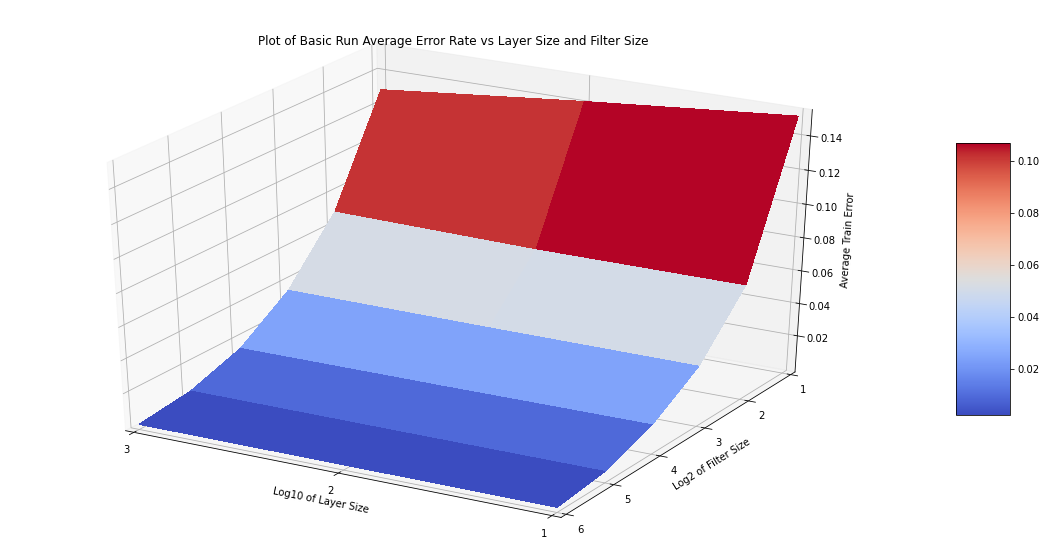

In [ ]:
# Plot Train
size_pow = np.log10(np.array(layer_sizes)); 
fb_pow = np.log2(np.array(filter_banks))
# Test Results
size_powgrid, fb_powgrid = np.meshgrid(size_pow,fb_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Log10 of Layer Size")
ax.set_yticks(fb_pow)
ax.set_xticks(size_pow)
ax.set_ylim(fb_pow[-1],fb_pow[0])
ax.set_xlim(size_pow[-1],size_pow[0])
ax.set_ylabel("Log2 of Filter Size")
ax.set_zlabel("Average Train Error")
ax.set_title("Plot of Basic Run Average Error Rate vs Layer Size and Filter Size")
MSE_surf = ax.plot_surface(size_powgrid, fb_powgrid, (res_train_mean.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

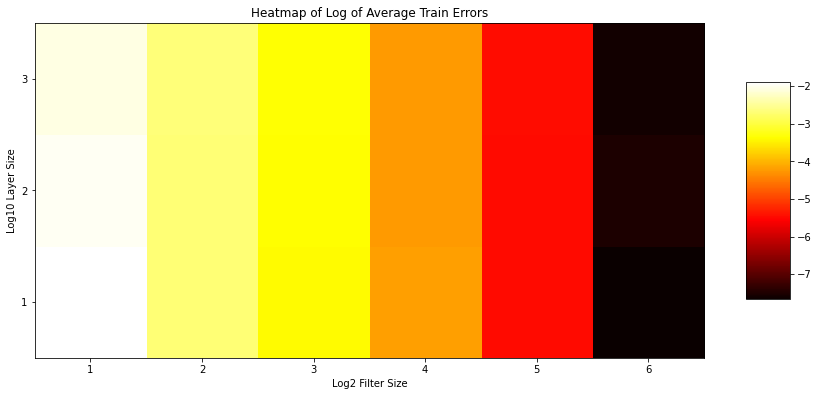

In [ ]:
# Train Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(res_train_mean), cmap="hot", origin="lower", 
           extent=[fb_pow[0]-0.5, fb_pow[-1]+0.5, size_pow[0]-0.5, size_pow[-1]+0.5])
plt.ylabel("Log10 Layer Size")
plt.yticks(size_pow)
plt.xlabel("Log2 Filter Size")
plt.xticks(fb_pow)
plt.title("Heatmap of Log of Average Train Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

### 2) Cross Validation

In [7]:
# Auxiliary Functions
def getSubArray(x_train, y_train,n, seed = None):
    """
    Divide the training set into n sub-arrays
    
    Inputs:
    x_train,y train: m x n and m x 1 respectively. 
    n: # of sub-arrays
    """
    res_x = []; res_y = []; sub_arr_indexes = []
    n_samples = x_train.shape[0]; inc = n_samples/n;
    
    # Set seed to get repeatable results
    if seed is not None:
        random.seed(seed)
    
    # Not needed to shuffle because already shuffled before splitting to train and test
    # shuffle the training data before splitting to sub-arrays
#     permute = random.sample(range(n_samples), n_samples)
#     x_train = x_train[permute,:]
#     y_train = y_train[permute,:]
    
    # divide into sub-arrays
    start_idx = 0; end_idx = 0
    for _ in range(n):
        end_idx += inc
        round_end = math.floor(end_idx)
        sub_arr_indexes.append((start_idx, round_end))
        res_x.append(x_train[start_idx:round_end,:])
        res_y.append(y_train[start_idx:round_end,:])
        start_idx = round_end
    
    return res_x, res_y, sub_arr_indexes

def catSubArrays(folds):
    """
    Function to concatenate multiple sub-arrays to a single m x n array
    Input:
    folds: a list of 2d arrays to concatenate
    """
    res = folds[0]
    for idx in range(1,len(folds)):
        res = np.concatenate([res,folds[idx]],axis = 0)
    return res

In [12]:
# Loop 20 times.
pair_errors = []; best_pairs = [];
num_iter = 20
layer_sizes = [10, 100, 1000]; filter_banks = [2, 4, 8, 16, 32, 64]
num_classes = 10; num_labels = 10
# Fixed hyperparameters
learn_rate = 0.001; reg_coeff = 0; drop_prob = 0.0; n_epochs = 200; layers = 2
all_pair_errors = np.zeros((len(layer_sizes), len(filter_banks),num_iter)) # store results of validation error of all pairs over all 20 cross validation
# Dummy Run
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 88)
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)
train_samples, train_labels, new_train, train_oh, test_samples, test_labels, new_test, test_oh = process_labels_SL(train_samples, train_labels, test_samples, test_labels)
nData, dim = train_samples.shape
batch_size = nData;
for it in range(num_iter):
    # Do 1 Cross Validation, and iterate 20 times
    start_val = time.time()
    n = 5;
    
    # Split for every run
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    train_labels = train_labels.astype(int); test_labels = test_labels.astype(int)
    
    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)
    
    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)
    
    # 1 5-fold cross validation starts here
    pairs_val_results = np.zeros((len(layer_sizes), len(filter_banks)))
    start_cv = time.time()
    for layer_ind in range(len(layer_sizes)):
        layer_size = layer_sizes[layer_ind]; start_d = time.time()
        for f_ind in range(len(filter_banks)):
            fb = filter_banks[f_ind]; nodes_per_layer = [layer_size, 10]
            # Loop through folds for a pair of hyperparameters
            val_indexes = np.arange(n); val_err = []
            start_folds = time.time()
            for val_idx in val_indexes:
                train_indexes = np.delete(val_indexes, val_idx)
                
                # Take one fold as val, rest becomes training
                val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)
                
                # Training set
                train_mini_samples = catSubArrays(x_train[train_indexes])
                train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)

                # Convert data to be compatible for NN training
                train_mini_samples, train_mini_labels, new_train, train_oh, val_samples, val_labels, new_val, val_oh = process_labels_SL(train_mini_samples, train_mini_labels, val_samples, val_labels)
                new_train2 = new_train.reshape(-1, 16, 16, 1)
                new_val2 = new_val.reshape(-1, 16, 16, 1)

                # Build nn
                tf.reset_default_graph()
                sess = tf.Session()
                MLP = build_model2(layers, nodes_per_layer, learn_rate, fb, num_labels = num_labels, hlactivation = 'relu')

                # Train and Predict
                init = tf.initialize_all_variables()
                sess.run(init)
                start_train = time.time()
                train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = train_model2(MLP, 200, batch_size, new_train2, train_mini_labels, train_oh, new_val2, val_labels, val_oh)
                print(f"Training done in {time.time() - start_train}")
                val_rate = 1 - val_acc_arr[-1]; train_rate = 1 - train_acc_arr[-1]

                # Append Results
                val_err.append(val_rate) # this is result of each/5 fold for one pair
                
            # Store this pair's results
            print(f"Time for one 5-fold over a pair is {time.time() - start_folds}")
            print(f"For Layer size = {layer_size} and filter size = {fb}, val error is {np.mean(val_err)}")
            pairs_val_results[layer_ind, f_ind] = np.mean(np.array(val_err))
            all_pair_errors[layer_ind, f_ind, it] = np.mean(np.array(val_err))
            
    # After done for all hyperparameters, re-train and re-evaluate on the best combination
    print(f"Time for one 5-fold over all pairs is {time.time() - start_cv}")
    [index_ls], [index_fb] = np.where(pairs_val_results == np.min(pairs_val_results))
    best_ls, best_fb = layer_sizes[index_ls], filter_banks[index_fb]
    
    print(f"For iteration {it+1}, best layer size is {best_ls} and best filter size is {best_fb}")
    
    # Re-train and predict

    # Adjust data
    train_samples, train_labels, new_train, train_oh, test_samples, test_labels, new_test, test_oh = process_labels_SL(train_samples, train_labels, test_samples, test_labels)
    new_train2 = new_train.reshape(-1, 16, 16, 1)
    new_test2 = new_test.reshape(-1, 16, 16, 1)

    # Build nn
    nodes_per_layer = [best_ls, 10];
    tf.reset_default_graph()
    sess = tf.Session()
    MLP = build_model2(layers, nodes_per_layer, learn_rate, best_fb, num_labels = num_labels, hlactivation = 'relu')

    # Train and Predict
    init = tf.initialize_all_variables()
    sess.run(init)
    start_train = time.time()
    train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = train_model2(MLP, 200, batch_size, new_train2, train_labels, train_oh, new_test2, test_labels, test_oh)
    print(f"Training done in {time.time() - start_train}")
    test_rate = 1 - val_acc_arr[-1]; train_rate = 1 - train_acc_arr[-1]
    
    
    # Append results of this round of cross-validation
    pair_errors.append(test_rate); best_pairs.append([best_ls, best_fb])
    
    print(f"Time for 1 cross validation is {time.time() - start_cv}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training done in 10.498595714569092
Training done in 3.7077646255493164
Training done in 3.603712558746338
Training done in 3.7129108905792236
Training done in 3.529402732849121
Time for one 5-fold over a pair is 26.217509984970093
For Layer size = 10 and filter size = 2, val error is 0.14022441807492897
Training done in 4.298822402954102
Training done in 4.216729640960693
Training done in 4.19076132774353
Training done in 4.05993914604187
Training done in 4.086226224899292
Time for one 5-fold over a pair is 21.874528884887695
For Layer size = 10 and filter size = 4, val error is 0.07555643534286396
Training done in 5.187440395355225
Training done in 5.13262152671814
Training done in 5.113018751144409
Training done in 5.126321792602539
Training done in 5.146660566329956
Time for one 5-fold over a pair is 26.753735303878784
For Layer size = 10 and filter size = 8, val error is 0.04261954863295514
Training done in 

In [13]:
# Analyse Results
av_val_error = np.mean(all_pair_errors, axis = -1)
# Observe that the filter sizes are chosen in powers to 2 to make the result's difference significant enough. Therefore, it makes sense to also observe the average of the power. Same
# intuition for the layer sizes
best_lsizes = np.array(best_pairs)[:, 0]; best_fsizes = np.array(best_pairs)[:, 1]
best_lsizes_pow = np.log10(best_lsizes); best_fsizes_pow = np.log2(best_fsizes)

# Compute mean and std of the best values
av_lsize = np.mean(best_lsizes); std_lsize = np.std(best_lsizes)
av_fsize = np.mean(best_fsizes); std_fsize = np.std(best_fsizes)

# Compute mean and std of the best powers
av_lsize_pow = np.mean(best_lsizes_pow); std_lsize_pow = np.std(best_lsizes_pow)
av_fsize_pow = np.mean(best_fsizes_pow); std_fsize_pow = np.std(best_fsizes_pow)

# Compute mean and std of the test errors
av_test_error = np.mean(pair_errors); std_test_error = np.std(pair_errors)


# Prints
print(f"The average best hidden layer size is {av_lsize} with std of {std_lsize}")
print(f"The average best filter size is {av_fsize} with std of {std_fsize}")
print(f"The average best hidden layer size power is {av_lsize_pow} with std of {std_lsize_pow}")
print(f"The average best filter size power is {av_fsize_pow} with std of {std_fsize_pow}")
print(f"The average best test error is {av_test_error} with std of {std_test_error}")

The average best hidden layer size is 433.0 with std of 464.2639335550415
The average best filter size is 64.0 with std of 0.0
The average best hidden layer size power is 2.1 with std of 0.8306623862918076
The average best filter size power is 6.0 with std of 0.0
The average best test error is 0.01690860215053764 with std of 0.0027960866149715244


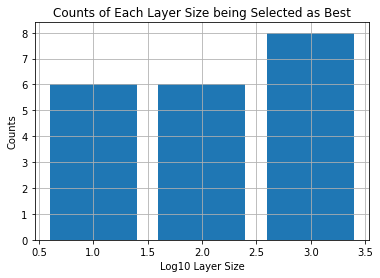

In [24]:
# Bar Chart for Layer Size
all_counts = np.zeros((len(layer_sizes)))
lsizes, counts = np.unique(best_lsizes_pow, return_counts = True)
all_counts[np.log10(layer_sizes) == lsizes] = counts

# Plot bar chart
plt.title("Counts of Each Layer Size being Selected as Best")
plt.bar(np.log10(layer_sizes), all_counts)
plt.xlabel('Log10 Layer Size')
plt.ylabel('Counts')
plt.grid()

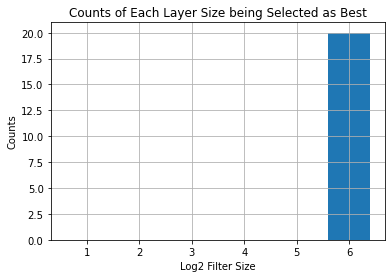

In [26]:
# Bar Chart for Layer Size
all_counts = np.zeros((len(filter_banks)))
fsizes, counts = np.unique(best_fsizes_pow, return_counts = True)
all_counts[np.log2(filter_banks) == fsizes] = counts

# Plot bar chart
plt.title("Counts of Each Layer Size being Selected as Best")
plt.bar(np.log2(filter_banks), all_counts)
plt.xlabel('Log2 Filter Size')
plt.ylabel('Counts')
plt.grid()

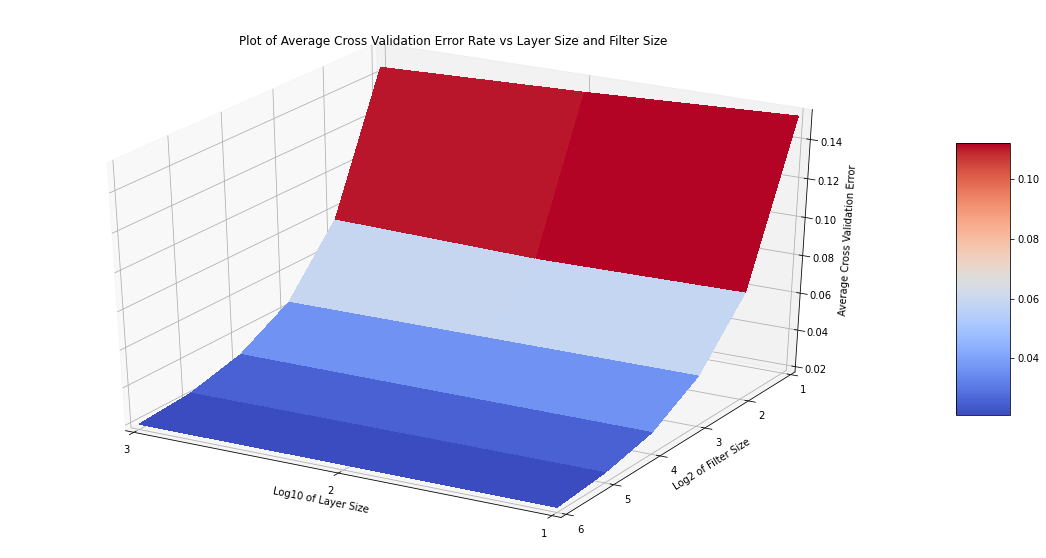

In [28]:
# Visualisation of validation performance during cross validations
# Plot 
size_pow = np.log10(np.array(layer_sizes));
fb_pow = np.log2(np.array(filter_banks))
# Test Results
size_powgrid, fb_powgrid = np.meshgrid(size_pow,fb_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Log10 of Layer Size")
ax.set_yticks(fb_pow)
ax.set_xticks(size_pow)
ax.set_ylim(fb_pow[-1],fb_pow[0])
ax.set_xlim(size_pow[-1],size_pow[0])
ax.set_ylabel("Log2 of Filter Size")
ax.set_zlabel("Average Cross Validation Error")
ax.set_title("Plot of Average Cross Validation Error Rate vs Layer Size and Filter Size")
MSE_surf = ax.plot_surface(size_powgrid, fb_powgrid, (av_val_error.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

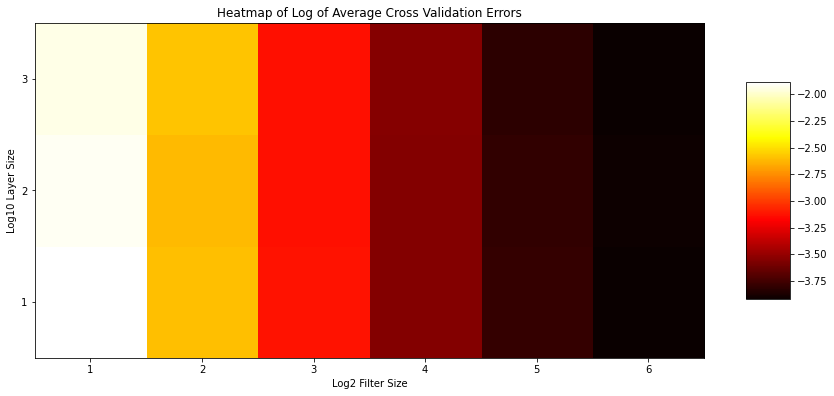

In [27]:
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(av_val_error), cmap="hot", origin="lower", 
           extent=[fb_pow[0]-0.5, fb_pow[-1]+0.5, size_pow[0]-0.5, size_pow[-1]+0.5])
plt.ylabel("Log10 Layer Size")
plt.yticks(size_pow)
plt.xlabel("Log2 Filter Size")
plt.xticks(fb_pow)
plt.title("Heatmap of Log of Average Cross Validation Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)